In [3]:
#importing libraries and dataset
import pandas as pd
import torch
import numpy as np
from mp_api.client import MPRester

with MPRester("3cc08jX8WHZOYwtfrU6KNl5urhUOy3xL") as mpr:
    docs = mpr.materials.summary.search(band_gap=(0.00001,5.5))

C:\Users\ramie\AppData\Local\Temp\ipykernel_2044\1729688048.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No module named 'phonopy'
No module named 'phonopy'


Retrieving SummaryDoc documents:   0%|          | 0/79068 [00:00<?, ?it/s]

c:\Users\ramie\AppData\Local\Programs\Python\Python311\Lib\site-packages\mp_api\client\core\client.py:829: UserWarning: Use the 'fields' argument to select only fields of interest to speed up data retrieval for large queries. Choose from: ['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total

In [4]:
#initializing lists
mean_atomic_numbers = []
max_atomic_numbers = []
min_atomic_numbers = []
std_atomic_numbers = []

a_parameters = []
b_parameters = []
c_parameters = []
alpha_parameters = []
beta_parameters = []
gamma_parameters = []

mean_distance_matrix = []
max_distance_matrix = []
min_distance_matrix = []
std_distance_matrix = []

band_gaps = []

input = []

In [5]:
#Preproccessing of data
for i in range(len(docs)):
    mean_atomic_numbers += [np.mean(docs[i].structure.atomic_numbers)]
    max_atomic_numbers += [np.max(docs[i].structure.atomic_numbers)]
    min_atomic_numbers += [np.min(docs[i].structure.atomic_numbers)]
    std_atomic_numbers += [np.std(docs[i].structure.atomic_numbers)]

    # Lattice parameters:
    a_parameters += [docs[i].structure.lattice.abc[0]]
    b_parameters += [docs[i].structure.lattice.abc[1]]
    c_parameters += [docs[i].structure.lattice.abc[2]]
    alpha_parameters += [docs[i].structure.lattice.angles[0]]
    beta_parameters += [docs[i].structure.lattice.angles[1]]
    gamma_parameters += [docs[i].structure.lattice.angles[2]]

    mean_distance_matrix += [np.mean(docs[i].structure.distance_matrix)]
    max_distance_matrix += [np.max(docs[i].structure.distance_matrix)]
    min_distance_matrix += [np.min(docs[i].structure.distance_matrix)]
    std_distance_matrix += [np.std(docs[i].structure.distance_matrix)]

    band_gaps.append([docs[i].band_gap])
    input.append([mean_atomic_numbers[i],max_atomic_numbers[i],min_atomic_numbers[i],std_atomic_numbers[i],a_parameters[i],b_parameters[i],c_parameters[i],alpha_parameters[i],beta_parameters[i],gamma_parameters[i],mean_distance_matrix[i],max_distance_matrix[i],min_distance_matrix[i],std_distance_matrix[i]])



In [6]:
#Converting the input into a tensor

input = torch.tensor(input, dtype = torch.float32)
band_gaps = torch.tensor(band_gaps, dtype = torch.float32)


In [7]:
#More library imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#ANN
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(14, 250)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(250, 500)
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(500, 750)
        self.dropout3 = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(750, 500)
        self.dropout4 = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.fc5 = nn.Linear(500,100)
        self.dropout5 = nn.Dropout(p=0.5)
        self.relu =nn.ReLU()
        self.fc6 = nn.Linear(100,1)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc6(x)

        return x

In [9]:
#For testing the code purposes
import random

small_input =[]
small_band_gaps =[]
inputlist = input.tolist()
band_gapslist = band_gaps.tolist()
for i in range(100):
    random_i = random.randint(0,len(docs))
    small_input.append(inputlist[i])
    small_band_gaps.append(band_gapslist[i])

small_input = torch.tensor(small_input)
small_band_gaps = torch.tensor(small_band_gaps)


Epoch [100/1000], Train Loss: 1.6728, Val Loss: 1.7211, Train MSE: 1.6728, Val MSE: 1.7211, Train MAE: 1.0574, Val MAE: 1.0753, Train R2: 0.1555, Val R2: 0.1464
Epoch [200/1000], Train Loss: 1.5434, Val Loss: 1.6134, Train MSE: 1.5434, Val MSE: 1.6134, Train MAE: 1.0163, Val MAE: 1.0426, Train R2: 0.2186, Val R2: 0.1999
Epoch [300/1000], Train Loss: 1.4763, Val Loss: 1.5668, Train MSE: 1.4763, Val MSE: 1.5668, Train MAE: 0.9881, Val MAE: 1.0215, Train R2: 0.2512, Val R2: 0.2226
Epoch [400/1000], Train Loss: 1.4378, Val Loss: 1.5397, Train MSE: 1.4378, Val MSE: 1.5397, Train MAE: 0.9740, Val MAE: 1.0119, Train R2: 0.2716, Val R2: 0.2357
Epoch [500/1000], Train Loss: 1.3986, Val Loss: 1.5196, Train MSE: 1.3986, Val MSE: 1.5196, Train MAE: 0.9566, Val MAE: 1.0011, Train R2: 0.2900, Val R2: 0.2456
Epoch [600/1000], Train Loss: 1.3682, Val Loss: 1.5002, Train MSE: 1.3682, Val MSE: 1.5002, Train MAE: 0.9445, Val MAE: 0.9912, Train R2: 0.3070, Val R2: 0.2551
Epoch [700/1000], Train Loss: 1.33

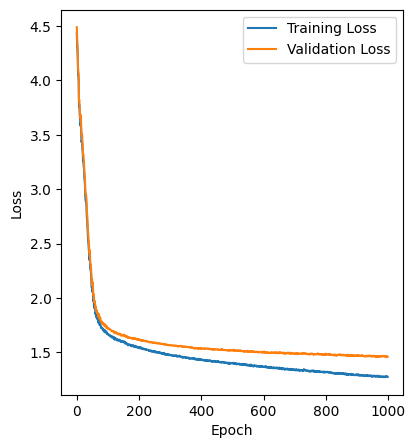

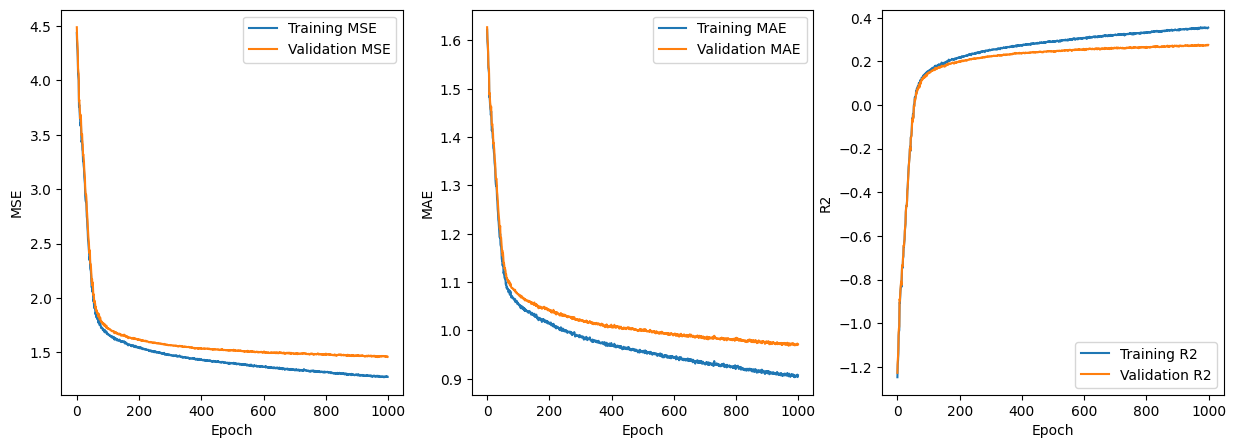

In [10]:
model = RegressionNN()

#Train on gpu and splitting up the data to training, validation and testing.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_temp, y_train, y_temp = train_test_split(input,band_gaps, test_size=0.3, random_state=64)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay= 1e-5)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

train_losses = []
val_losses = []

# Lists to store training and validation MSEs and MAEs for plotting
train_mses = []
val_mses = []
train_maes = []
val_maes = []

train_r2s = []
val_r2s = []

# Training the model
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        train_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        train_r2 = 0.0
        total_train = 0

        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device).float(), train_labels.to(device).float()
            train_outputs = model(train_inputs)
            train_loss += criterion(train_outputs, train_labels).item()
            train_mse += nn.functional.mse_loss(train_outputs, train_labels).item()
            train_mae += nn.functional.l1_loss(train_outputs, train_labels).item()
            train_r2 += r2_score(train_labels.cpu().numpy(), train_outputs.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_mse = train_mse / len(train_loader)
        avg_train_mae = train_mae / len(train_loader)
        avg_train_r2 = train_r2 / len(train_loader)

        val_loss = 0.0
        val_mse = 0.0
        val_mae = 0.0
        val_r2 = 0.0
        total_val = 0

        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device).float(), val_labels.to(device).float()
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_mse += nn.functional.mse_loss(val_outputs, val_labels).item()
            val_mae += nn.functional.l1_loss(val_outputs, val_labels).item()
            val_r2 += r2_score(val_labels.cpu().numpy(), val_outputs.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mse = val_mse / len(val_loader)
        avg_val_mae = val_mae / len(val_loader)
        avg_val_r2 = val_r2 / len(val_loader)

    # Append losses and metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_mses.append(avg_train_mse)
    val_mses.append(avg_val_mse)
    train_maes.append(avg_train_mae)
    val_maes.append(avg_val_mae)
    train_r2s.append(avg_train_r2)
    val_r2s.append(avg_val_r2)

    # Print the training and validation statistics every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train MSE: {avg_train_mse:.4f}, Val MSE: {avg_val_mse:.4f}, Train MAE: {avg_train_mae:.4f}, Val MAE: {avg_val_mae:.4f}, Train R2: {avg_train_r2:.4f}, Val R2: {avg_val_r2:.4f}')

# Plotting the training and validation loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation MSE curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_mses, label='Training MSE')
plt.plot(val_mses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plotting the training and validation MAE curves
plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Training MAE')
plt.plot(val_maes, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plotting the training and validation R2 curves
plt.subplot(1, 3, 3)
plt.plot(train_r2s, label='Training R2')
plt.plot(val_r2s, label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

In [11]:
# Testing the model
model.eval()  # Set the model to evaluation mode
test_mse = 0.0
test_mae = 0.0
test_r2 = 0.0
total_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device).float(), test_labels.to(device).float()
        test_outputs = model(test_inputs)
        test_mse += nn.functional.mse_loss(test_outputs, test_labels).item()
        test_mae += nn.functional.l1_loss(test_outputs, test_labels).item()
        test_r2 += r2_score(test_labels.cpu().numpy(), test_outputs.cpu().numpy())

    avg_test_mse = test_mse / len(test_loader)
    avg_test_mae = test_mae / len(test_loader)
    avg_test_r2 = test_r2 / len(test_loader)

print(f'Test MSE: {avg_test_mse:.4f}, Test MAE: {avg_test_mae:.4f}, Test R2: {avg_test_r2:.4f}')


Test MSE: 1.4176, Test MAE: 0.9520, Test R2: 0.2789


Epoch [100/1000]
Model 1 - Epoch [100/1000], Train MSE: 1.7397, Val MSE: 1.8014, Train R2: 0.1202, Val R2: 0.1066, Train MAE: 1.0647, Val MAE: 1.0870
Model 2 - Epoch [100/1000], Train MSE: 1.8391, Val MSE: 1.8909, Train R2: 0.0690, Val R2: 0.0626, Train MAE: 1.0960, Val MAE: 1.1160
Model 3 - Epoch [100/1000], Train MSE: 1.8317, Val MSE: 1.8788, Train R2: 0.0745, Val R2: 0.0684, Train MAE: 1.0911, Val MAE: 1.1083
Epoch [200/1000]
Model 1 - Epoch [200/1000], Train MSE: 1.6585, Val MSE: 1.7268, Train R2: 0.1609, Val R2: 0.1437, Train MAE: 1.0419, Val MAE: 1.0669
Model 2 - Epoch [200/1000], Train MSE: 1.6093, Val MSE: 1.6806, Train R2: 0.1838, Val R2: 0.1665, Train MAE: 1.0303, Val MAE: 1.0568
Model 3 - Epoch [200/1000], Train MSE: 1.6712, Val MSE: 1.7234, Train R2: 0.1548, Val R2: 0.1452, Train MAE: 1.0444, Val MAE: 1.0644
Epoch [300/1000]
Model 1 - Epoch [300/1000], Train MSE: 1.5910, Val MSE: 1.6646, Train R2: 0.1945, Val R2: 0.1743, Train MAE: 1.0235, Val MAE: 1.0517
Model 2 - Epoch [3

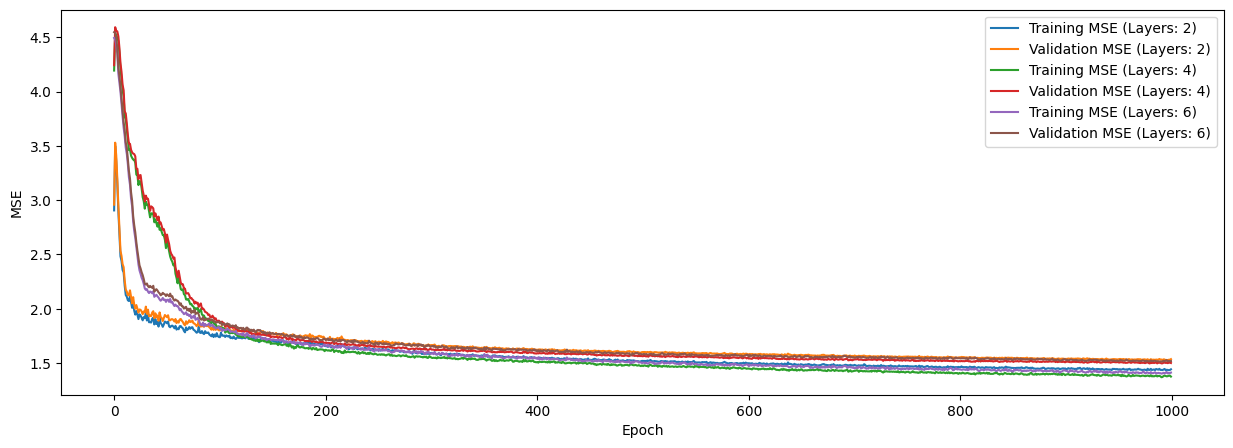

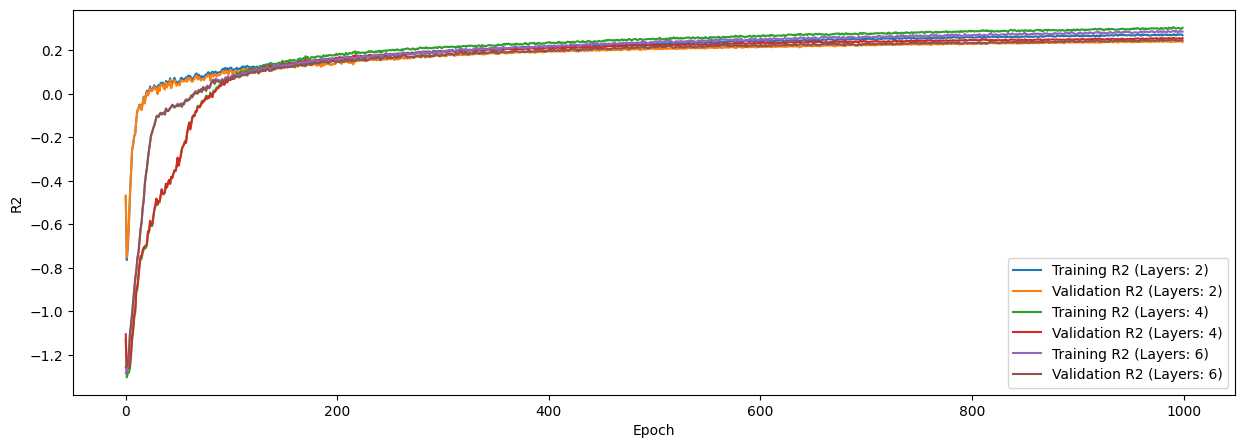

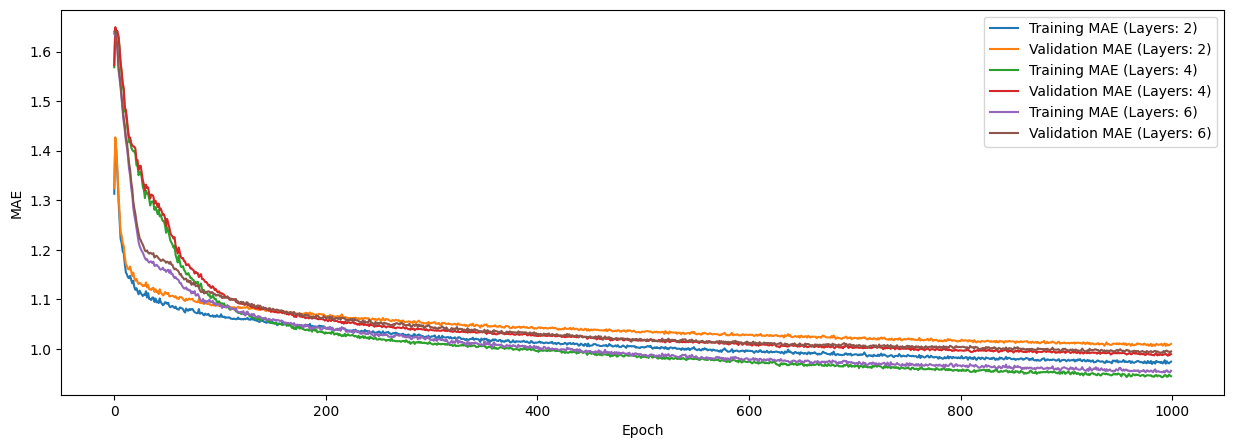

In [12]:
#Ensemble training code

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

class RegressionNN(nn.Module):
    def __init__(self, num_layers):
        super(RegressionNN, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(14, 250))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=0.5))
        
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(250, 250))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=0.5))
        
        self.layers.append(nn.Linear(250, 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Initialize models
models = [RegressionNN(num_layers) for num_layers in [2, 4, 6]]

# Train on gpu and splitting up the data to training, validation and testing.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_temp, y_train, y_temp = train_test_split(input, band_gaps, test_size=0.3, random_state=64)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=64)

for model in models:
    model.to(device)

criterion = nn.MSELoss()
optimizers = [optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) for model in models]

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Training the models
num_epochs = 1000

train_mses = [[] for _ in range(len(models))]
val_mses = [[] for _ in range(len(models))]
train_r2s = [[] for _ in range(len(models))]
val_r2s = [[] for _ in range(len(models))]
train_maes = [[] for _ in range(len(models))]
val_maes = [[] for _ in range(len(models))]

for epoch in range(num_epochs):
    for model_idx, model in enumerate(models):
        model.train()
        optimizer = optimizers[model_idx]
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            train_mse = 0.0
            train_r2 = 0.0
            train_mae = 0.0
            for train_inputs, train_labels in train_loader:
                train_inputs, train_labels = train_inputs.to(device).float(), train_labels.to(device).float()
                train_outputs = model(train_inputs)
                train_mse += criterion(train_outputs, train_labels).item()
                train_r2 += r2_score(train_labels.cpu().numpy(), train_outputs.cpu().numpy())
                train_mae += np.abs(train_labels.cpu().numpy() - train_outputs.cpu().numpy()).mean()

            avg_train_mse = train_mse / len(train_loader)
            avg_train_r2 = train_r2 / len(train_loader)
            avg_train_mae = train_mae / len(train_loader)

            val_mse = 0.0
            val_r2 = 0.0
            val_mae = 0.0
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device).float(), val_labels.to(device).float()
                val_outputs = model(val_inputs)
                val_mse += criterion(val_outputs, val_labels).item()
                val_r2 += r2_score(val_labels.cpu().numpy(), val_outputs.cpu().numpy())
                val_mae += np.abs(val_labels.cpu().numpy() - val_outputs.cpu().numpy()).mean()

            avg_val_mse = val_mse / len(val_loader)
            avg_val_r2 = val_r2 / len(val_loader)
            avg_val_mae = val_mae / len(val_loader)

            train_mses[model_idx].append(avg_train_mse)
            val_mses[model_idx].append(avg_val_mse)
            train_r2s[model_idx].append(avg_train_r2)
            val_r2s[model_idx].append(avg_val_r2)
            train_maes[model_idx].append(avg_train_mae)
            val_maes[model_idx].append(avg_val_mae)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        for model_idx, model in enumerate(models):
            print(f'Model {model_idx + 1} - Epoch [{epoch+1}/{num_epochs}], Train MSE: {train_mses[model_idx][-1]:.4f}, Val MSE: {val_mses[model_idx][-1]:.4f}, Train R2: {train_r2s[model_idx][-1]:.4f}, Val R2: {val_r2s[model_idx][-1]:.4f}, Train MAE: {train_maes[model_idx][-1]:.4f}, Val MAE: {val_maes[model_idx][-1]:.4f}')

# Plotting the training and validation MSE curves
plt.figure(figsize=(15, 5))
for i in range(len(models)):
    plt.plot(train_mses[i], label=f'Training MSE (Layers: {2*i+2})')
    plt.plot(val_mses[i], label=f'Validation MSE (Layers: {2*i+2})')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Plotting the training and validation R2 curves
plt.figure(figsize=(15, 5))
for i in range(len(models)):
    plt.plot(train_r2s[i], label=f'Training R2 (Layers: {2*i+2})')
    plt.plot(val_r2s[i], label=f'Validation R2 (Layers: {2*i+2})')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.show()

# Plotting the training and validation MAE curves
plt.figure(figsize=(15, 5))
for i in range(len(models)):
    plt.plot(train_maes[i], label=f'Training MAE (Layers: {2*i+2})')
    plt.plot(val_maes[i], label=f'Validation MAE (Layers: {2*i+2})')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [13]:
# Testing the ensemble of models
test_losses = [[] for _ in range(len(models))]
test_r2s = [[] for _ in range(len(models))]

for model_idx, model in enumerate(models):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_r2 = 0.0

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device).float(), test_labels.to(device).float()
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()
            test_r2 += r2_score(test_labels.cpu().numpy(), test_outputs.cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        avg_test_r2 = test_r2 / len(test_loader)

        test_losses[model_idx].append(avg_test_loss)
        test_r2s[model_idx].append(avg_test_r2)

        print(f'Model {model_idx + 1} - Test Loss: {avg_test_loss:.4f}, Test R2: {avg_test_r2:.4f}')


Model 1 - Test Loss: 1.4895, Test R2: 0.2431
Model 2 - Test Loss: 1.4526, Test R2: 0.2618
Model 3 - Test Loss: 1.4837, Test R2: 0.2459
